In this notebook we show how to use btk with user input custom functions.
The tutorial shows how to:
1. generate blends sampled randomly from catsim catalog, while the distance between them is also drawn from a distrution.
2. blends are drawn from a pre-processed wld output with objects being assigned to a "group" if any of their pixels overlap.
3. randomly pick galaxy from the catsim catalog and generate images of objects within a specified distance from it.
4. genrate blends with different observing conditions (PSF size and exposure time)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import random
import galsim
import sys
import descwl
import astropy.table
import numpy as np

#import scarlet.display to plot RGB images if scarelt is installed
if 'scarlet' in sys.modules:
    import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config

In [2]:
# Functions helpful for plotting blend images
def get_rgb(image, min_val=None, max_val=None):
    """Basic function to normalize 3 band input image to rgb 0-255 image"""
    assert image.shape[0] == 3, "must be 3 channel in dimension 1"
    if min_val is None:
        min_val = image.min(axis=-1).min(axis=-1) 
    if max_val is None:
        max_val = image.max(axis=-1).max(axis=-1) 
    new_image = np.transpose(image, axes=(1,2,0))
    new_image = (new_image - min_val) / (max_val-min_val)*255
    new_image[new_image<0] = 0
    new_image[new_image>255] = 255
    return new_image.astype(np.uint8)

def get_rgb_image(image, normalize_with_image=None):
    """Returns RGB (0-255) image corresponding to the input 3 band image.
    If scarlet.display is imported then the normalization is performed by
    scarlet Asinh function. If not, a basic normalization is performed."""
    if 'scarlet.display' not in sys.modules:
        if normalize_with_image is None:
            min_val = None
            max_val = None
        else:
            min_val = np.min(normalize_with_image, axis=1).min(axis=-1)
            max_val = np.max(normalize_with_image, axis=1).max(axis=-1)
        img_rgb = get_rgb(image, min_val=min_val, max_val=max_val)
    else:
        norm = scarlet.display.Asinh(img=normalize_with_image, Q=20)
        img_rgb = scarlet.display.img_to_rgb(image, norm=norm)
    return img_rgb

def plot_blends( blend_images, blend_list, detected_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, sum in all bands, and RGB with centers of objects marked"""
    batch_size = len(blend_list)
    if detected_centers is None:
        detected_centers = [[]]*batch_size
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = get_rgb_image(images)
        plt.figure(figsize=(8,3))
        plt.subplot(131)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(np.sum(blend_images[i, :, :, :], axis=2))
        plt.title("Sum")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(blend_img_rgb)
        plt.title("%i objects with centers"%num)
        for entry in blend_list[i]:
            plt.plot(entry['dx'], entry['dy'],'rx')
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.axis('off')
        plt.show()

## 1. Custom sampling function
### generate blends sampled randomly from catsim catalog, while the distance between them is also drawn from a distrution.

- Galaxies are sampled randomly from an input Catsim catalog.
- Select only galaxies with i band magnitude < 24 and r-i >1.
- Number of galaxies in each blend is modelled as a poisson distribution of mean 3.
- x and y coordinates of the galaxies are a determined from normal distribution of 1 arcsec standard deviation.


In [8]:
# new sampling functions

def new_center_shift(Args, number_of_objects):
    """Shift galaxy centers with a value drawn from a normal distribution with
    mean 0 and std 1 arcseconds."""
    mean, sigma = 0, 1 #arcseconds
    dx = np.random.normal(mean, sigma, number_of_objects)
    dy = np.random.normal(mean, sigma, number_of_objects)
    return dx, dy
    
def new_sampling_function(Args, catalog):
    """Returns catalog with parametrs to draw one blend scene.
    
    Samples galaxies with i<24, r-i>1. Number of objects ber blend is selected from a poisson
    distribution of mean 3. The number of objects is restricted to max_number. The centers of the objects 
    are set in new function new_center_shift().
    Note:Sampling function must clip the number of objects to Args.max_number!
    """
    # Determine number of objets per blend
    number_of_objects = np.random.poisson(3)
    number_of_objects = np.minimum(number_of_objects, Args.max_number)
    
    # Make galaxy sample
    q, = np.where((catalog['i_ab'] <= 25.2) & (np.abs(catalog['i_ab'] - catalog['r_ab']) >1))
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    
    # galaxy centers are sent as random shift from 0,0
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = new_center_shift(Args, number_of_objects)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    return blend_catalog

In [9]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data/OneDegSq.fits')
# Load parameters
param = config.Simulation_params(catalog_name, max_number=6, batch_size=5)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

#Generate catalogs of blended objects 
blend_genrator = btk.create_blend_generator.generate(param, catalog, new_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_genrator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_genrator, observing_genrator)    

<IPython.core.display.Javascript object>


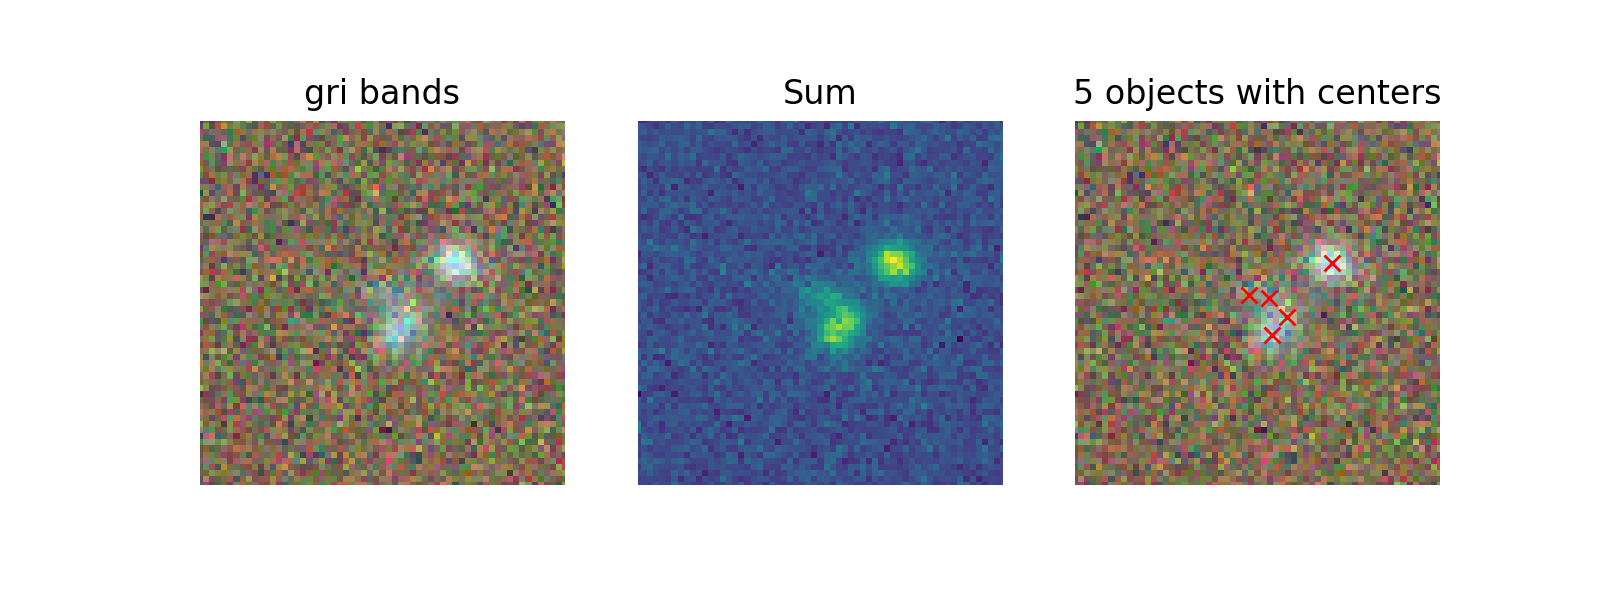

<IPython.core.display.Javascript object>


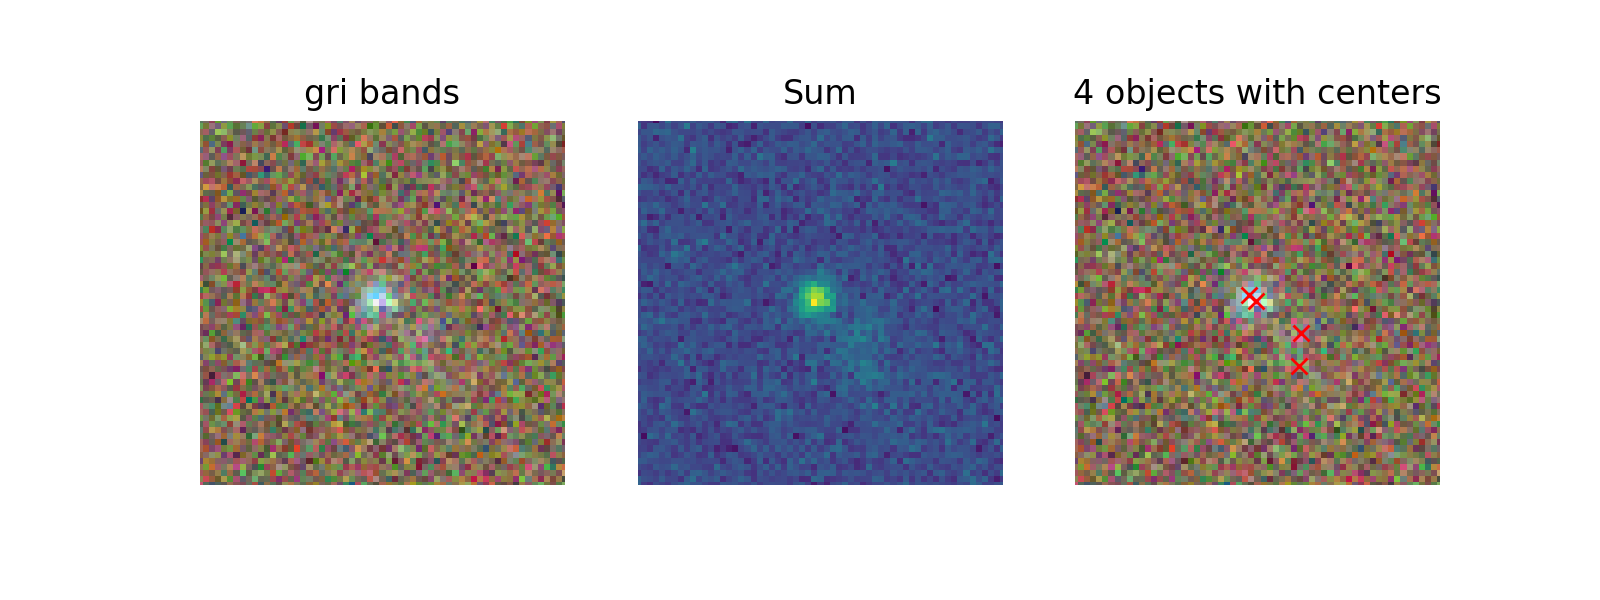

<IPython.core.display.Javascript object>


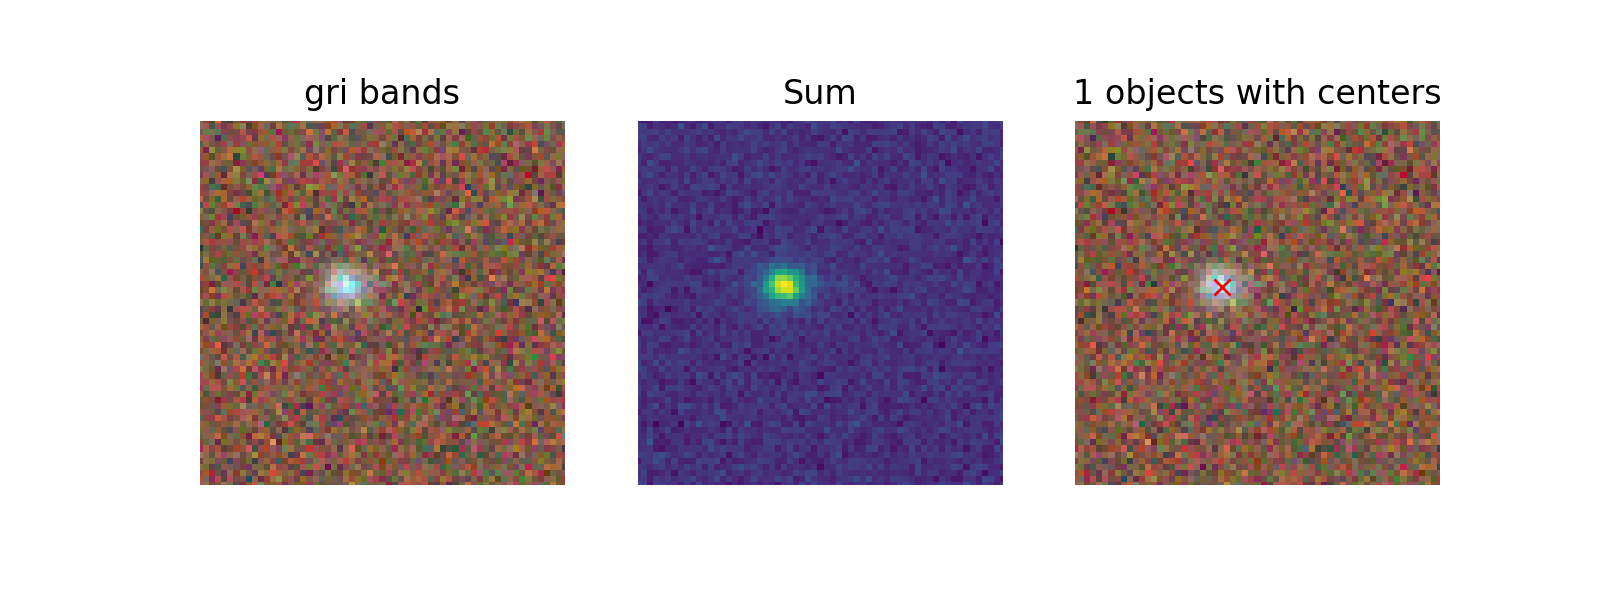

<IPython.core.display.Javascript object>


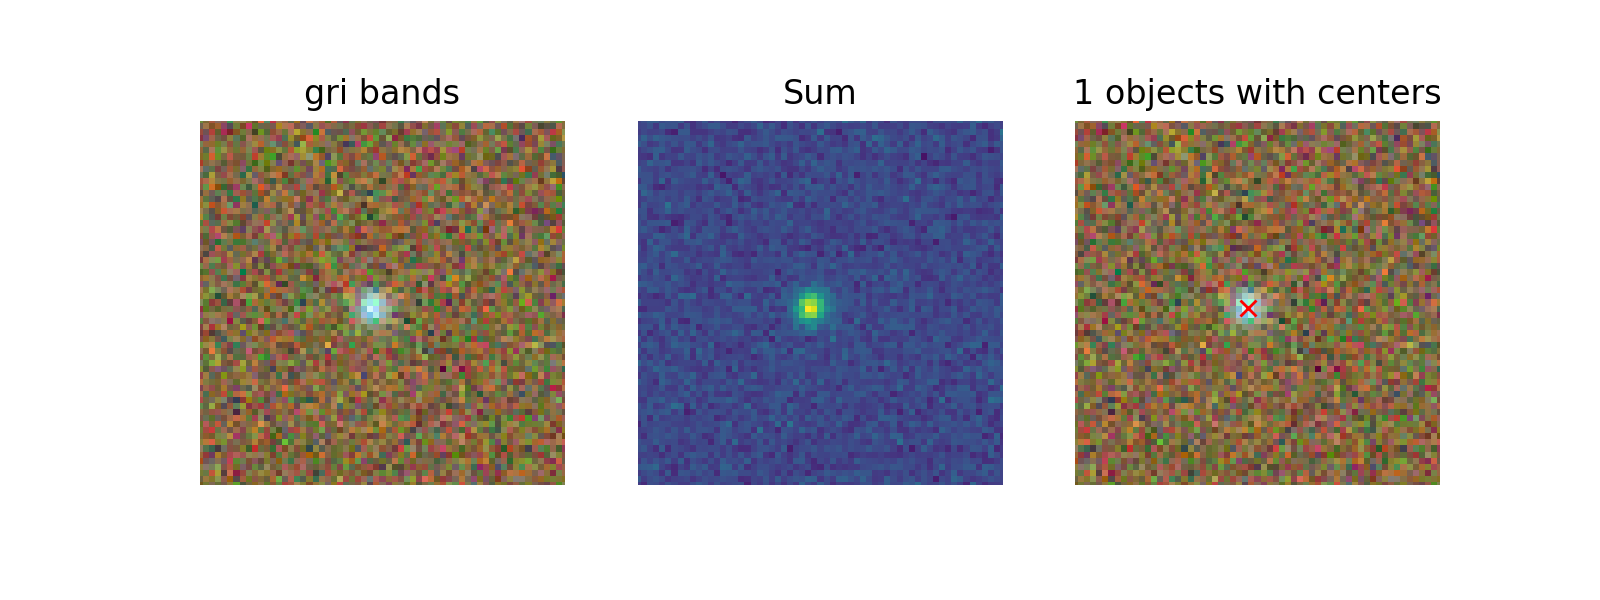

<IPython.core.display.Javascript object>


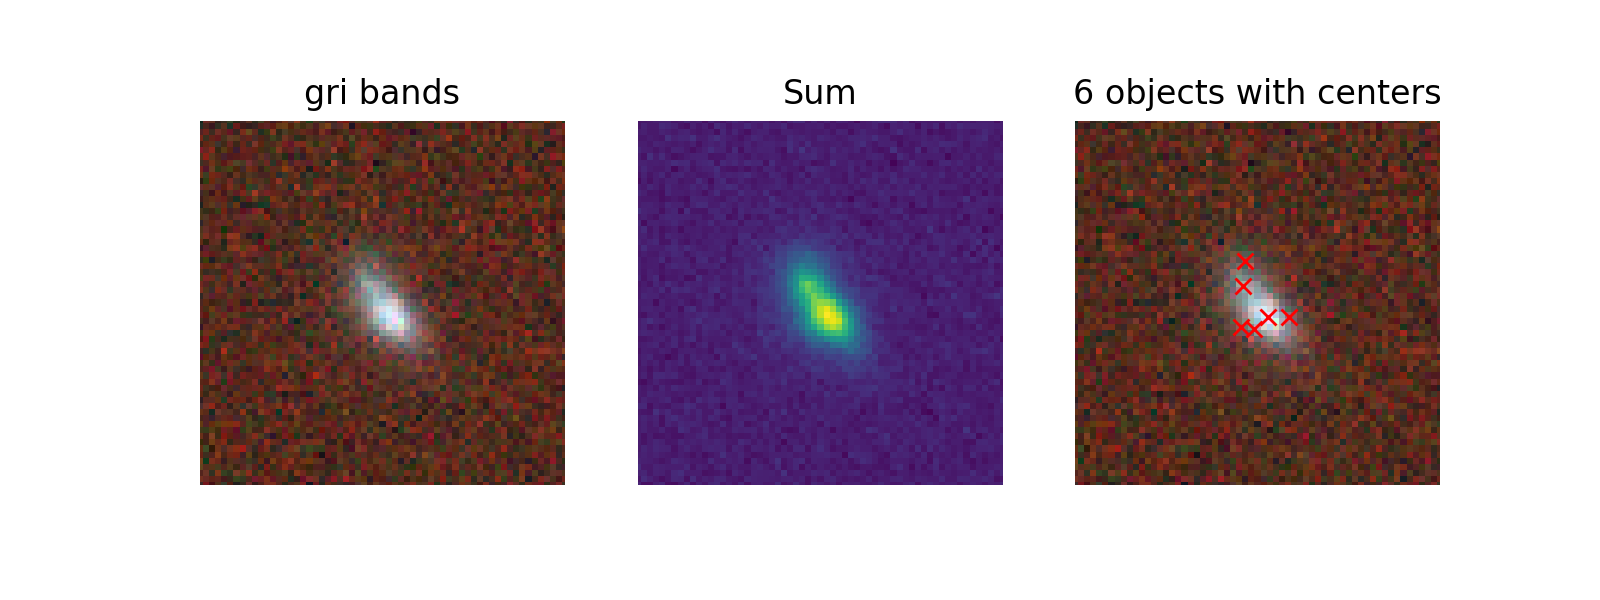

In [10]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends(blend_images, blend_list, limits=(30,90))

## 2. Blends drawn as galaxies part of a group detremined by wld
### blends are drawn from a pre-processed wld output with objects being assigned to a group if any of their pixels overlap. 

Use real galaxy blend configurations from the input Catsim catalog. The input wld processed catalog consists of galaxy parameters whose profiles were drawn upto a threshold where the pixel value was of 0.1x std of noise in the i band. A group consistis of all galaxies that have atleast one overlapping counterpart in the group. See wld [documentation](https://weaklensingdeblending.readthedocs.io/en/latest/index.html) for more details.

We define a `group_sampling_function` to sample groups from this catalog and draw them.

We also demonstrate how a selection function can be used to make sure only objects that pass teh selection criterion are drawned. here `basic_selection_function` makes sure only galaxies that are brighter than 27 mag in i band amd smaller than 2 arcsec are drawn.

In [11]:
def get_random_shift(Args, number_of_objects, maxshift=None):
    """Returns a random shift in x and y coordinates
    between 0 and max-shift (in arcseconds).
    """
    if not maxshift:
        maxshift = Args.stamp_size / 30.  # in arcseconds
    dx = np.random.uniform(-maxshift, maxshift,
                           size=number_of_objects)
    dy = np.random.uniform(-maxshift, maxshift,
                           size=number_of_objects)
    return dx, dy

def group_sampling_function(Args, catalog):
    """Blends are defined from *groups* of galaxies from the CatSim
    catalog previously analyzed with WLD.

    The group is centered on the middle of the postage stamp.
    Function only draws galaxies that lie within the postage stamp size
    determined in Args.
    
    Note: the pre-run WLD images are not used here. We only use the pre-run
    catalog (in i band) to identify galaxies that belong to a group.
    """
    if not hasattr(Args, 'wld_catalog'):
        raise Exception(
            "A pre-run WLD catalog should be input as Args.wld_catalog")
    else:
        wld_catalog = Args.wld_catalog 
    # randomly sample a group.
    group_ids = np.unique(wld_catalog['grp_id'][wld_catalog['grp_size'] >= 2])
    group_id = np.random.choice(group_ids, replace=False)
    # get all galaxies belonging to the group.
    ids = wld_catalog['db_id'][wld_catalog['grp_id'] == group_id]
    blend_catalog = astropy.table.vstack([catalog[catalog['galtileid'] == i] for i in ids])
    # Set mean x and y coordinates of the group galaxies to the center of the postage stamp. 
    blend_catalog['ra'] -= np.mean(blend_catalog['ra'])
    blend_catalog['dec'] -= np.mean(blend_catalog['dec'])
    # convert ra dec from degrees to arcsec
    blend_catalog['ra'] *= 3600
    blend_catalog['dec'] *= 3600
    # Add small random shift so that center does not perfectly align with stamp center
    dx, dy = get_random_shift(Args, 1, maxshift=3*Args.pixel_scale)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    # make sure galaxy centers don't lie too close to edge
    cond1 = np.abs(blend_catalog['ra']) < Args.stamp_size/2. - 3
    cond2 = np.abs(blend_catalog['dec']) < Args.stamp_size/2. - 3
    no_boundary = blend_catalog[cond1 & cond2]
    if len(no_boundary) == 0:
        return no_boundary
    # make sure number of galaxies in blend is less than Args.max_number
    # randomly select max_number of objects if larger.
    num = min([len(no_boundary), Args.max_number])
    select = np.random.choice(range(len(no_boundary)), num, replace=False)
    return no_boundary[select]

def basic_selection_function(catalog):
    """Apply selection cuts to the input catalog"""
    a = np.hypot(catalog['a_d'], catalog['a_b'])
    q, = np.where((a <= 2) & (catalog['i_ab'] <= 27))
    return catalog[q]

In [15]:
# Load catalog reviously run through WLD
wld_catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data/sample_group_catalog.fits')

#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'data/OneDegSq.fits')
param = config.Simulation_params(catalog_name, max_number=10, batch_size=6)
param.wld_catalog_name = wld_catalog_name
np.random.seed(param.seed)
# Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)#, selection_function=btk.utils.basic_selection_function)

# Generate catlogs of blended objects. 
# Input group_sampling_function here
blend_generator = btk.create_blend_generator.generate(param, catalog, btk.utils.group_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

<IPython.core.display.Javascript object>


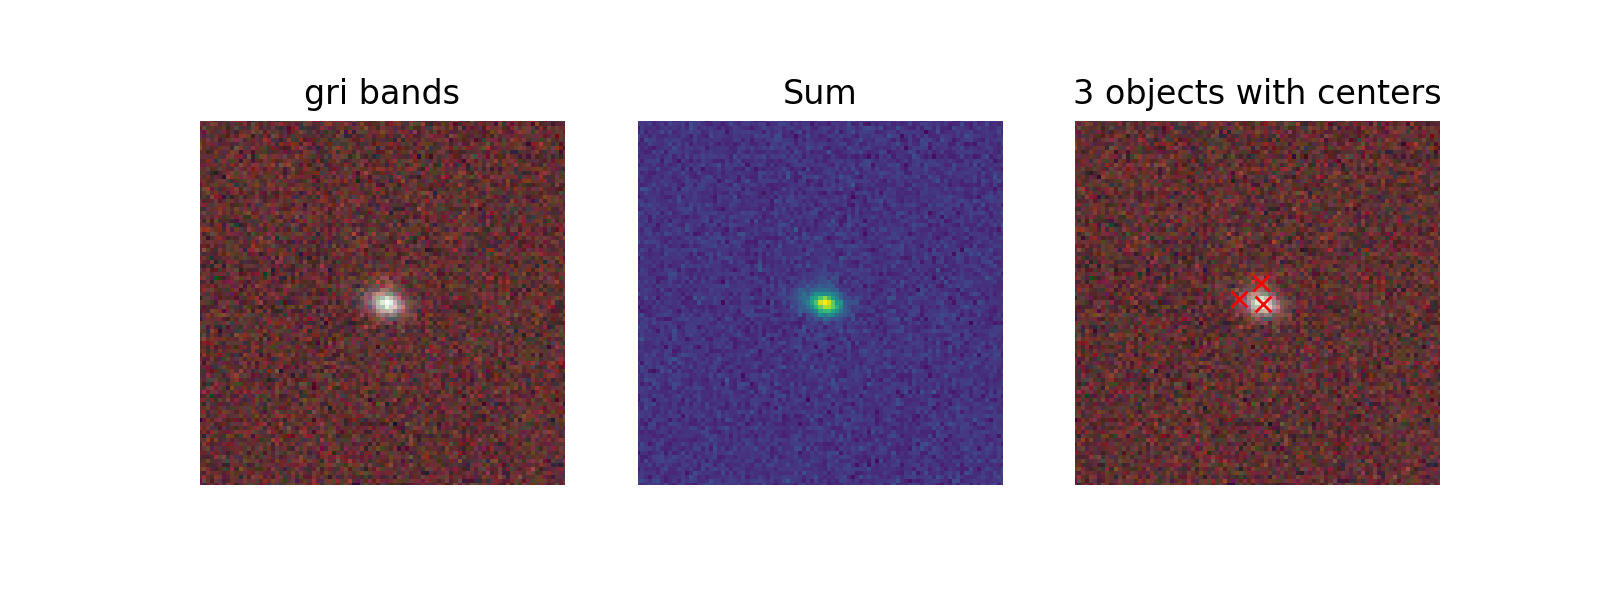

<IPython.core.display.Javascript object>


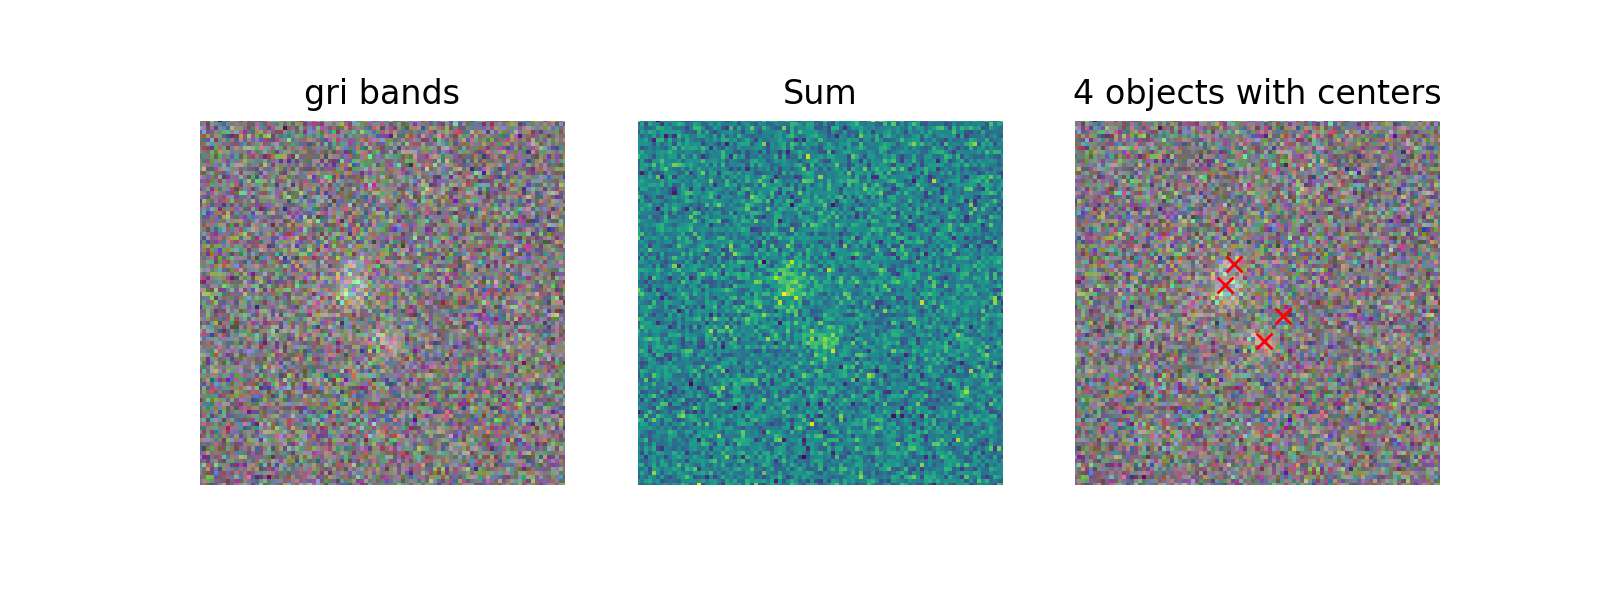

<IPython.core.display.Javascript object>


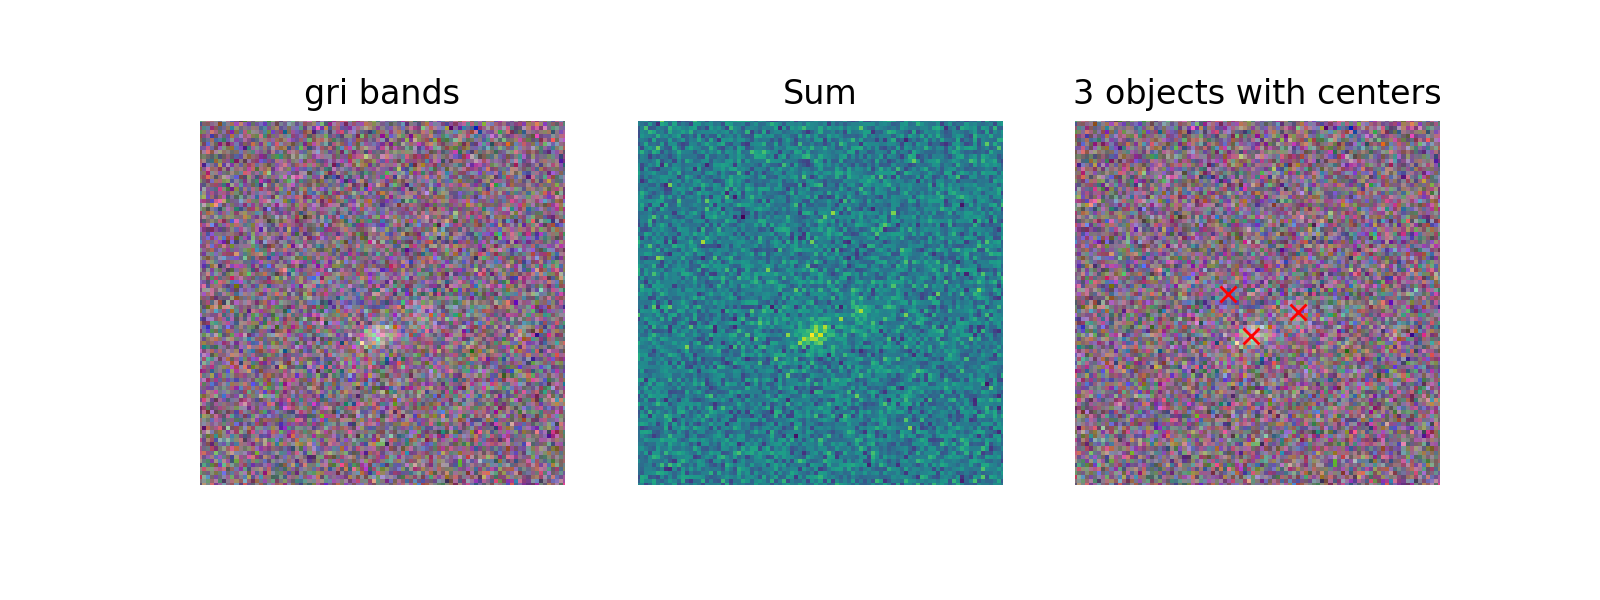

<IPython.core.display.Javascript object>


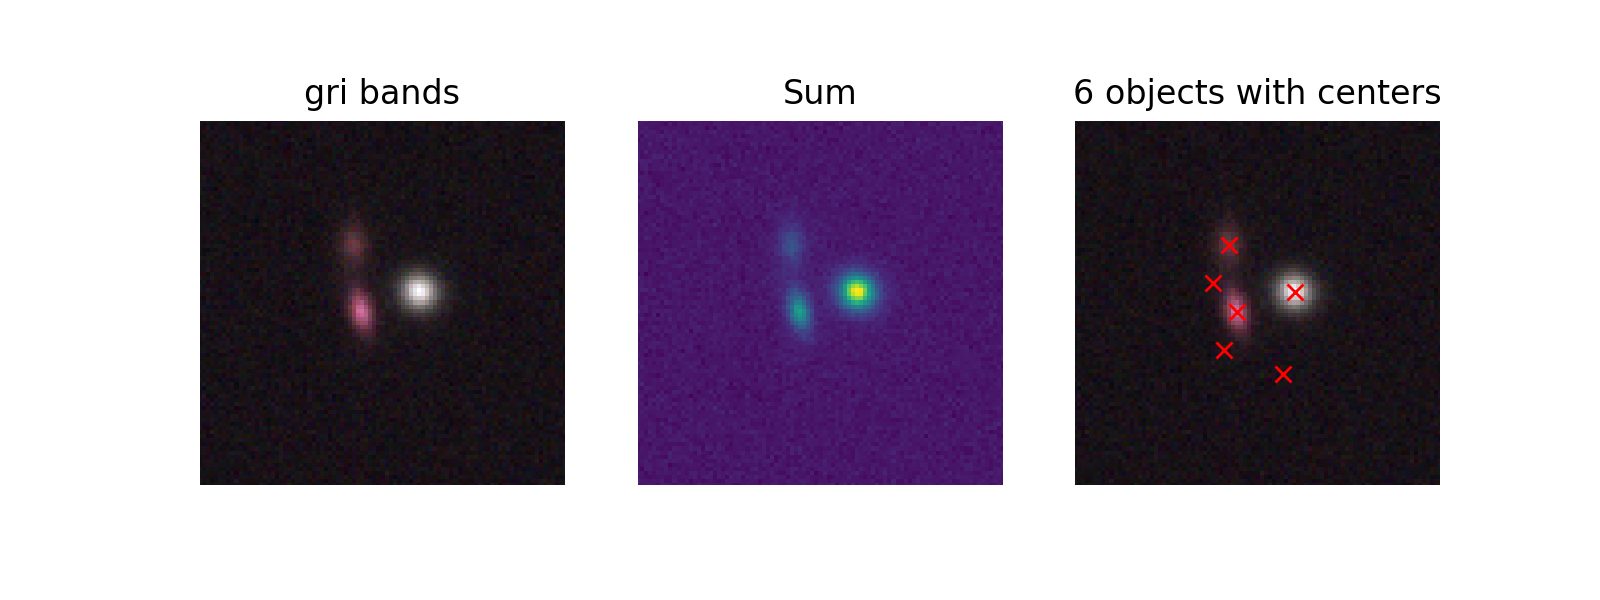

<IPython.core.display.Javascript object>


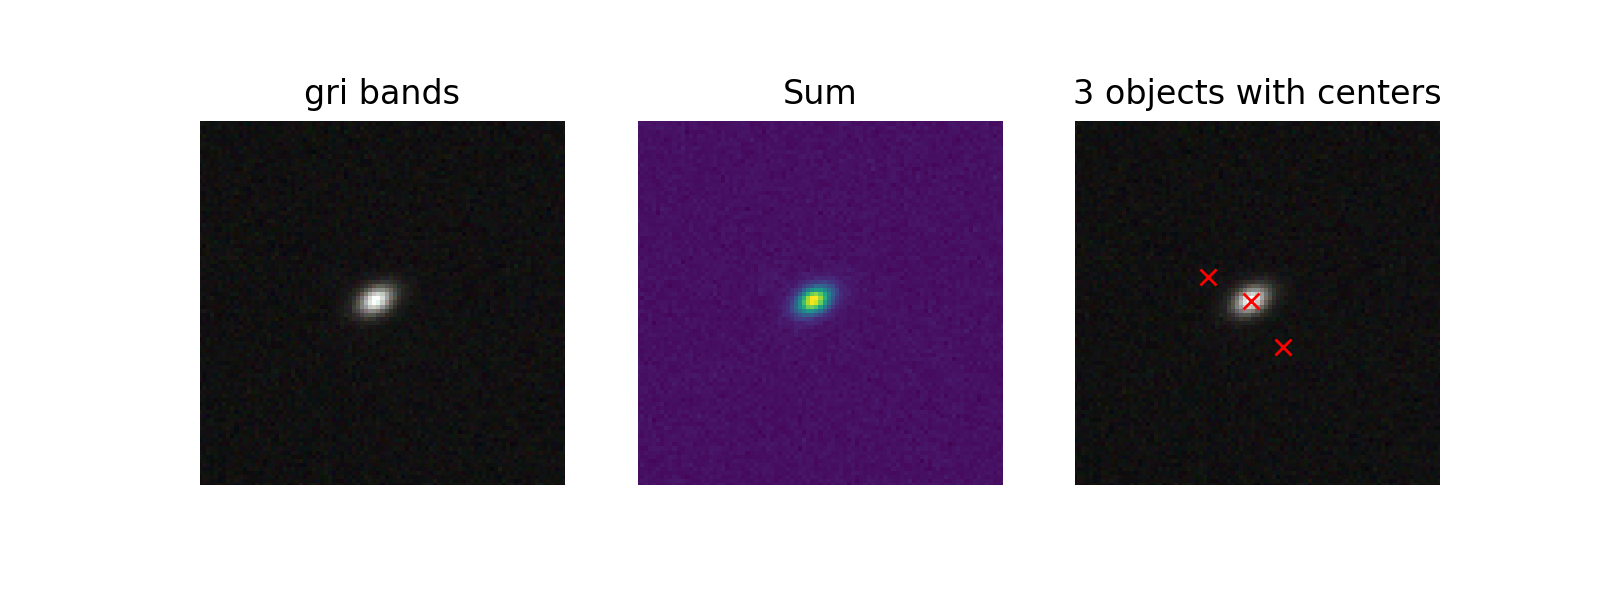

<IPython.core.display.Javascript object>


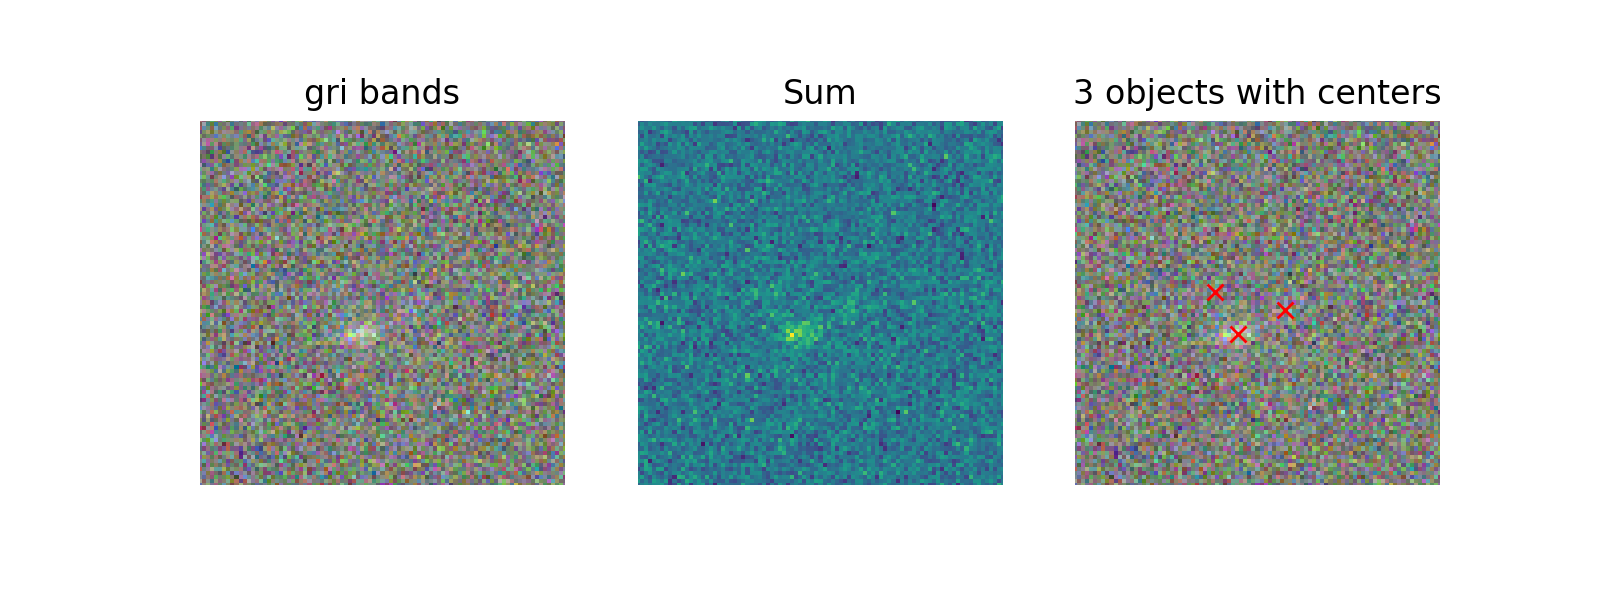

In [16]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends(blend_images, blend_list, limits=(15,105))

## 3. Draw all galaxies within a radius
### randomly pick galaxy from the catsim catalog and generate images of objects within a specified distance from it.

We define a function `select_within_radius` that picks a galaxy at random and creates a blend scene with it and all objects within a radius of stamp size/5. 

We also define a new selection function `select_only_gold` that draws only the galaxies in the gold sample (i<25.2)

In [17]:
def select_within_radius(Args, catalog):
    """Returns all galaxies within a radius of stamp_size/5 of a randomly
    selected galaxy from the input catalog.
    
    Function centers the blend to the middle of the postage stamp. It also
    limits the number of objects to max_number
    """
    pick_gal = np.random.choice(len(catalog), 1)
    dx = (catalog['ra'] - catalog['ra'][pick_gal]) * 3600
    dy = (catalog['dec']- catalog['dec'][pick_gal]) * 3600
    dh = np.hypot(dx,dy)  
    q, = np.where(dh < Args.stamp_size/5.)
    blend_catalog = catalog[q]
    # Set mean x and y coordinates of the group galaxies to the center of the postage stamp. 
    blend_catalog['ra'] -= np.mean(blend_catalog['ra'])
    blend_catalog['dec'] -= np.mean(blend_catalog['dec'])
    # convert ra dec from degrees to arcsec
    blend_catalog['ra'] *= 3600
    blend_catalog['dec'] *= 3600
    # Add small random shift so that center does not perfectly align with stamp center
    dx, dy = get_random_shift(Args, 1, maxshift=3*Args.pixel_scale)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    # make sure number of galaxies in blend is less than Args.max_number
    # randomly select max_number of objects if larger.
    num = min([len(blend_catalog), Args.max_number])
    select = np.random.choice(range(len(blend_catalog)), num, replace=False)
    return blend_catalog[select]

def select_only_gold(catalog):
    """Apply selection cuts to the input catalog"""
    a = np.hypot(catalog['a_d'], catalog['a_b'])
    q, = np.where(catalog['i_ab'] <= 25.2)
    return catalog[q]

In [19]:
param = config.Simulation_params(catalog_name, max_number=10, batch_size=4)

np.random.seed(param.seed)
# Load input catalog
catalog = btk.get_input_catalog.load_catalog(param, selection_function=select_only_gold)

# Generate catlogs of blended objects. 
# Input group_sampling_function here
blend_generator = btk.create_blend_generator.generate(param, catalog, select_within_radius)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

<IPython.core.display.Javascript object>


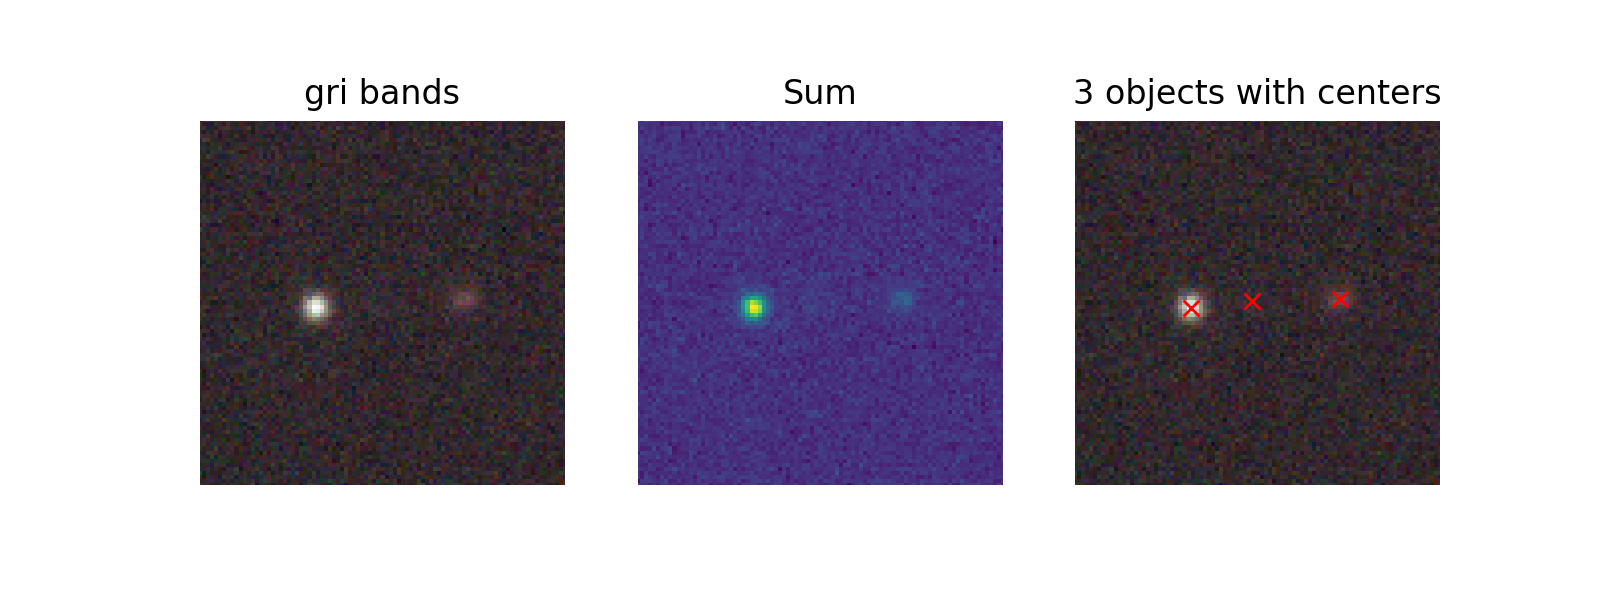

<IPython.core.display.Javascript object>


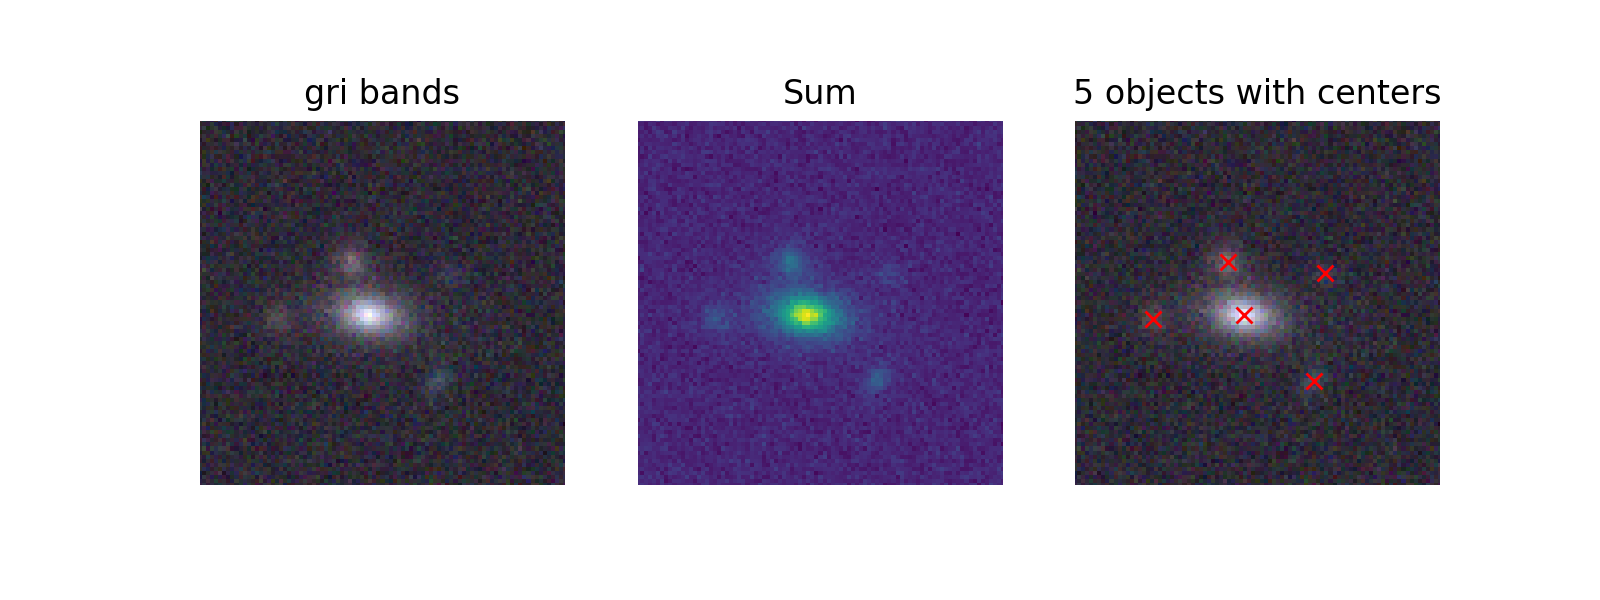

<IPython.core.display.Javascript object>


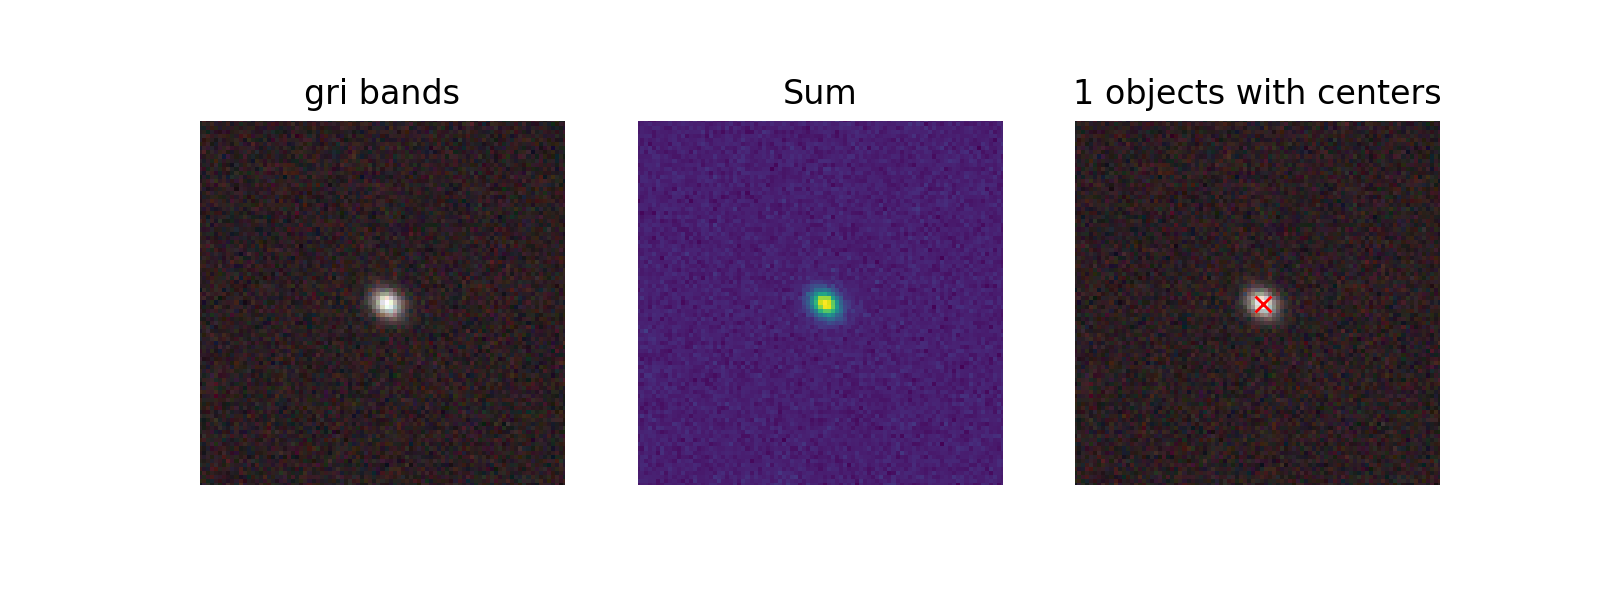

<IPython.core.display.Javascript object>


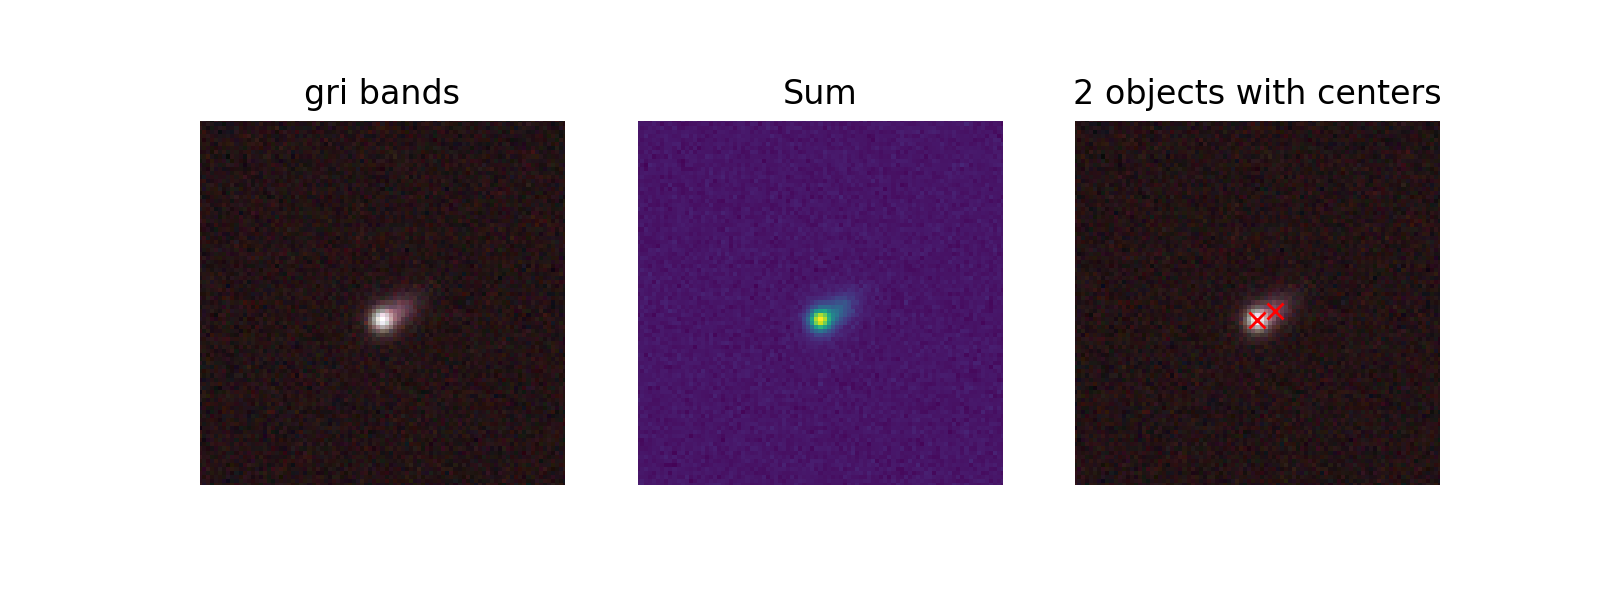

In [20]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends(blend_images, blend_list, limits=(15,105))


## 4. Using custom observing condition
### genrate blends with different observing conditions (PSF size and exposure time)

Here we define a `custom_obs_condition` that selects different observing condition for each band and blend. Each blend in the batch will have different seeing (atmosphere effects) and PSF (telescope effects). 
The exposure time is selected from a uniform distribution between 100s and the LSST survey default. The PSF fwhm is perturbed slightly from the default FWHM by a value sampled uniformly between -0.1 to 0.1 arcsec.

To show this we input a catalog with just 1 galaxy, so that our batch has the same object.

In [28]:
def custom_obs_condition(Args, band):
    """Returns observing conditions from the WLD package
    for a given survey_name and band with a small offset from
    the default parametrs.
    Args
        Args: Class containing parameters to generate blends
        band: filter name to get observing conditions for.
    Returns
        survey: WLD survey class with observing conditions.
    """
    survey = descwl.survey.Survey.get_defaults(
        survey_name=Args.survey_name,
        filter_band=band)
    survey['exposure_time'] = random.uniform(100, survey['exposure_time'])
    survey['zenith_psf_fwhm'] += random.uniform(-0.1,0.1)
    return survey

def plot_blends_same_scale(blend_images, blend_list, detected_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, and i band image"""
    batch_size = len(blend_list)
    if detected_centers is None:
        detected_centers = [[]]*batch_size
    norm = scarlet.display.Asinh(img=np.transpose(blend_images[0, :, :, 1:4], axes=(2,0,1)),
                                 Q=20)
    vmin, vmax = np.min(blend_images[0, :, :, 3]), np.max(blend_images[0, :, :, 3])
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(6,3))
        plt.subplot(121)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(blend_images[i, :, :, 3],
                  vmin=vmin, vmax=vmax)
        plt.title("i band")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')


In [31]:
param = config.Simulation_params(catalog_name, max_number=1, batch_size=4)
np.random.seed(param.seed)
random.seed(param.seed)
#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param, selection_function=basic_selection_function)
catalog = catalog[catalog['i_ab']<23][13:14]
#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param, obs_function=custom_obs_condition)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

<IPython.core.display.Javascript object>


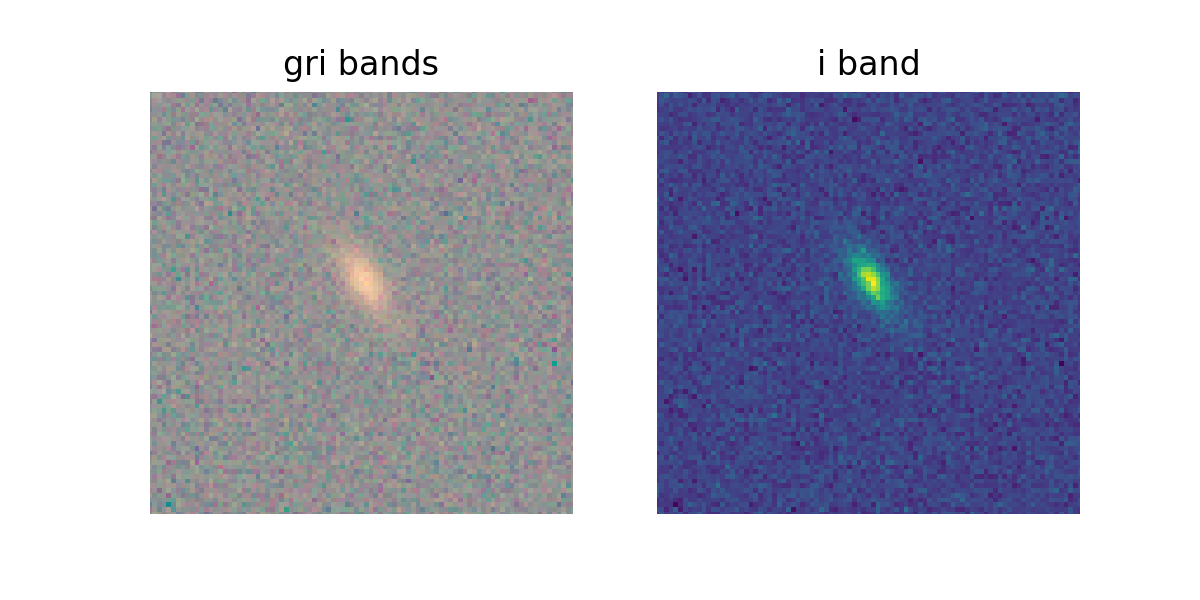

<IPython.core.display.Javascript object>


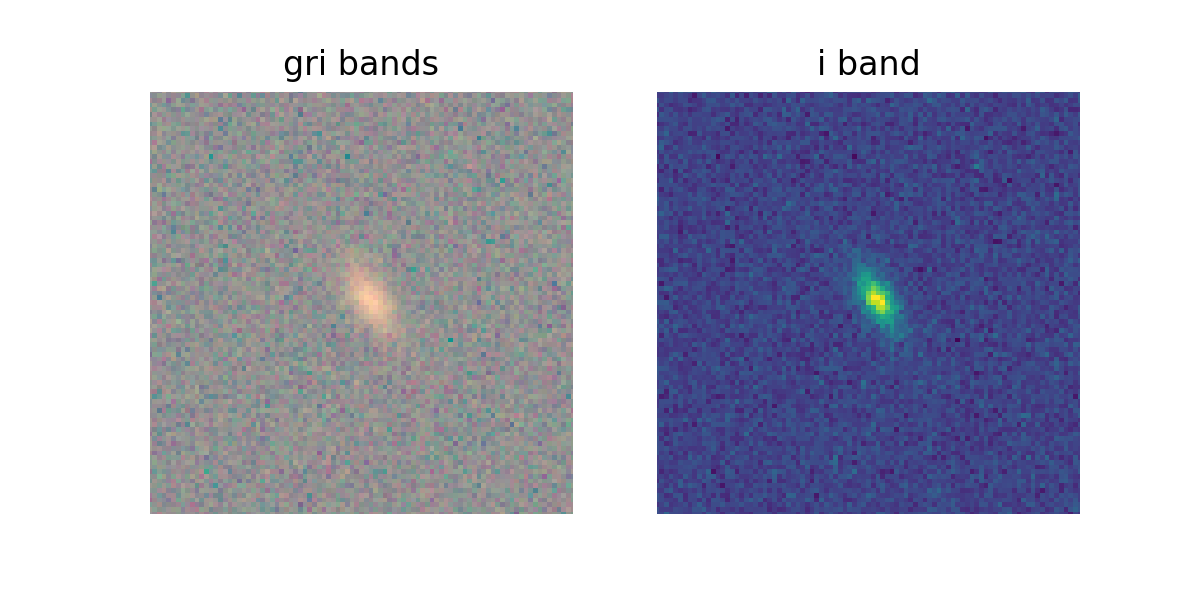

<IPython.core.display.Javascript object>


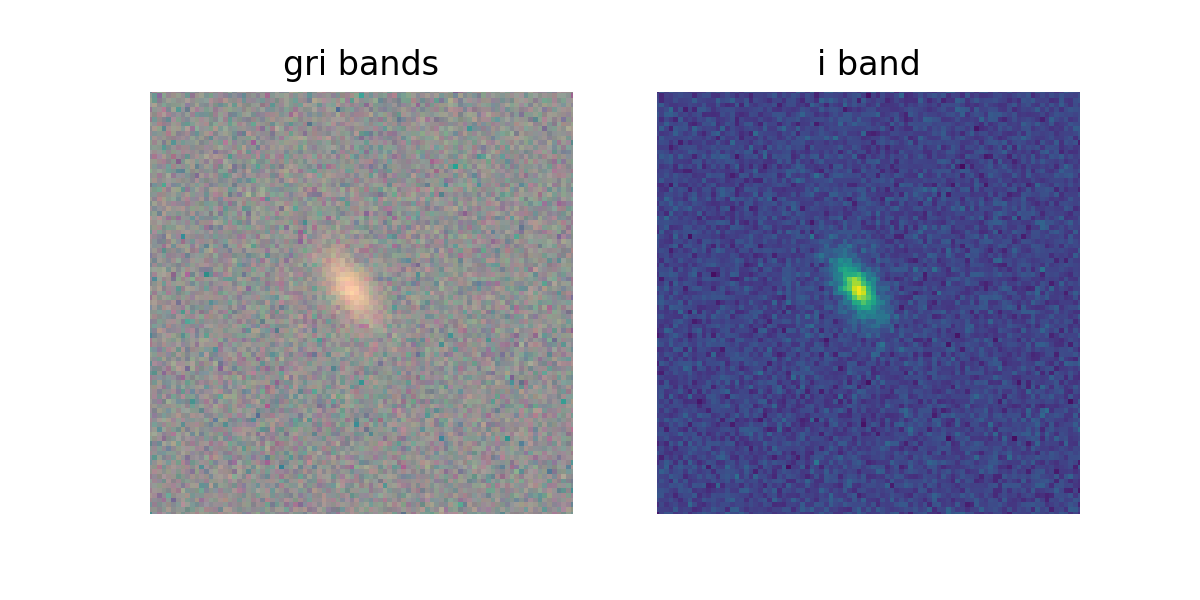

<IPython.core.display.Javascript object>


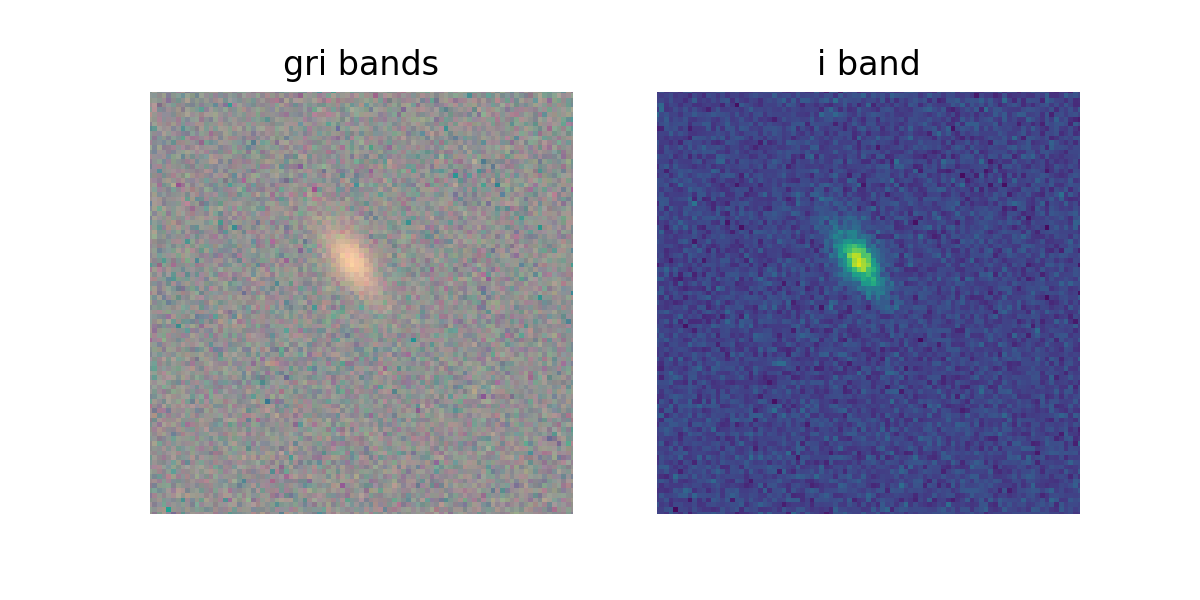

In [32]:
# Same galaxy is drawn with different observing conditions. All image shave same color scale. 

# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends_same_scale(blend_images, blend_list, limits=(15,105))